## Data Jobs in the UK

## Introduction

As someone who is relatively new to the field of Data, despite working with Data for the entirity of my career, I want understand more about the job market.

To understand the Job Market, I want to delve into the effects that certain skill sets have on wages, what skills are most desired in the Data market and what the wage scale looks like for different roles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import scipy.stats
import random

from pandas.io.formats.style import Styler
from collections import Counter
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import spearmanr, stats, normaltest, anderson

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)

In [2]:
data = pd.read_csv('deduped-jobs.csv')

df = pd.DataFrame(data)

## Cleaning and Transforming the Data

In this section, I will clean the data. In doing so, I will be removing all unwanted columns, ensuring data usable and all unwanted entries are removed.

In [3]:
df.sample()

,reference,title,date_posted,date_ending,advertiser,location,city,country,salary,salary_min,salary_max,salary_frequency,salary_currency,description
411,41752936,Principal Data Engineer - Asset Managers,2021-01-14,2021-02-25T23:55:00.0000000,Hays Specialist Recruitment Limited,South East England,London,GB,70000.0,70000.0,90000.0,YEAR,NaN,Apply now\nPrincipal Data Engineer at a leadin...


In [4]:
df.isnull().sum()

reference             0
title                 0
date_posted           0
date_ending           0
advertiser            0
location              0
city                  0
country               0
salary                0
salary_min            0
salary_max            0
salary_frequency      0
salary_currency     595
description           0
dtype: int64

In [5]:
pd.crosstab(index=df['location'], columns='count')
pd.crosstab(index=df['city'], columns='count')

col_0,count
city,
Abingdon,1
Alderley Edge,1
Banbury,1
Bath,4
Beckenham,1
Belfast,1
Berkshire,2
Birmingham,14
Bournemouth,3


In [6]:
# Ensuring all cities and locations are in the same letter case.
df['location'] = df['location'].str.lower()
df['city'] = df['city'].str.lower()

# Making sure any place within London, changes their city to London and Location to South East England.
df['city'] = np.where((df['location'] == 'london'), "london", df['city'])
df['city'] = np.where((df['city'] == 'uxbridge'), "london", df['city'])
df['location'] = np.where((df['location'] == 'london') & (df['city'] == 'london'),
                          "south east england", df['location'])

# Capitalising all locations
df['location'] = df['location'].str.title()
df['city'] = df['city'].str.title()

In [7]:
# Creating a new column.
df['job_category'] = ''

# Ensuring all titles are the same letter case.
df['title'] = df['title'].str.lower()

# Giving jobs the appropriate job category.
df['job_category'] = np.where((df['title'].str.contains('sql')), "data", df['job_category'])
df['job_category'] = np.where((df['title'].str.contains('dba')), "data", df['job_category'])
df['job_category'] = np.where((df['title'].str.contains("data")), "data", df['job_category'])
df['job_category'] = np.where((df['title'].str.contains("recruitment")), "recruitment", df['job_category'])
df['job_category'] = np.where((df['title'].str.contains("recruiter")), "recruitment", df['job_category'])

# Grouping all entries that are not considered "data"
df1 = df[~(df['job_category'] == "data")].index

# Removing all jobs which are not in the "data" job category.
df.drop(df1, inplace=True)

# Ensuring all entries are of the "data" job category.
pd.crosstab(index=df['job_category'], columns='count')

col_0,count
job_category,
data,377


In [8]:
# Removing all unnecessary columns.
df.drop(['reference','salary_currency','date_posted', 'date_ending','country','salary_frequency', 'salary_min', 'salary_max'], axis=1, inplace=True)

In [9]:
df.sample()

,title,advertiser,location,city,salary,description,job_category
7,head of data science,Harnham,South East England,London,100000.0,"Apply now\nHead of Data Science\nLondon, UK\n£...",data


## Data Analysis

In this section, I will look to explore, analyse, visualise and communicate my findings with the data.

Firstly, I want to see what are most commonly asked for skills within the data industry.

In [10]:
# Initialize a tally variable
tally_python = 0

# Iterate through rows and count occurrences of 'python'
for index, row in df.iterrows():
    description = row['description']
    if 'python' in description.lower():  # Convert to lowercase for case-insensitive matching
        tally_python += 1

# Initialize a tally variable
tally_sql = 0

# Iterate through rows and count occurrences of 'sql'
for index, row in df.iterrows():
    description = row['description']
    if 'sql' in description.lower():  # Convert to lowercase for case-insensitive matching
        tally_sql += 1

# Initialize a tally variable
tally_excel = 0

# Iterate through rows and count occurrences of 'excel'
for index, row in df.iterrows():
    description = row['description']
    if 'excel' in description.lower():  # Convert to lowercase for case-insensitive matching
        tally_excel += 1

# Initialize a tally variable
tally_powerbi = 0

# Iterate through rows and count occurrences of 'powerbi'
for index, row in df.iterrows():
    description = row['description']
    if 'power bi' in description.lower():  # Convert to lowercase for case-insensitive matching
        tally_powerbi += 1

# Initialize a tally variable
tally_oracle = 0

# Iterate through rows and count occurrences of 'oracle'
for index, row in df.iterrows():
    description = row['description']
    if 'oracle' in description.lower():  # Convert to lowercase for case-insensitive matching
        tally_oracle += 1

# Initialize a tally variable
tally_azure = 0

# Iterate through rows and count occurrences of 'azure'
for index, row in df.iterrows():
    description = row['description']
    if 'azure' in description.lower():  # Convert to lowercase for case-insensitive matching
        tally_azure += 1

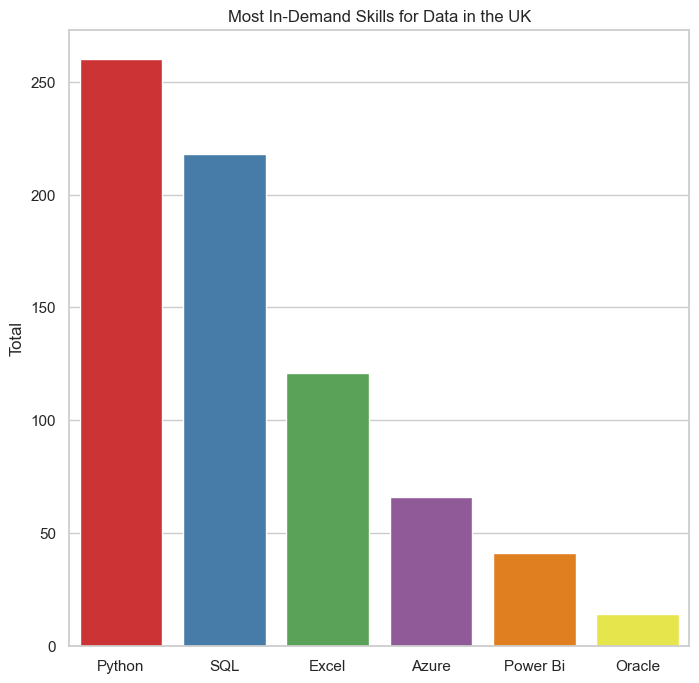

In [11]:
# List1
Software = ['Python', 'SQL', 'Excel', 'Azure', 'Power Bi', 'Oracle']
  
# List2
Total = [tally_python, tally_sql, tally_excel, tally_azure, tally_powerbi, tally_oracle]
  
# get the list of tuples from two lists.
# and merge them by using zip().
piechart = list(zip(Software, Total))
  
# Assign data to tuples.
piechart

# Converting lists of tuples into
# pandas Dataframe.
df_bar = pd.DataFrame(piechart,
                  columns=['Software', 'Total'])

sns.set(style="whitegrid") 
plt.figure(figsize=(8, 8)) 

# Specify custom colors for each bar
colours = sns.color_palette("Set1", len(df_bar))

# Create the bar plot
barplot = sns.barplot(x='Software', y='Total', data=df_bar, palette=colours)

# Set plot labels and title
plt.xlabel("")
plt.ylabel("Total")
plt.title("Most In-Demand Skills for Data in the UK")

# Show the plot
plt.show()

## Conclusion

Looking at the Bar Chart, it shows that Python and SQL are easily the most desirable skills in Data. I am going to further explore them when taking location in to consideration. Before doing so, I want to look at Location information.

## Location

I am looking at the distribution of the salaries in certain cities look like.

In [12]:
# Define the salary ranges
salary_ranges = range(10000, 170000, 10000)

# Initialize lists to store data for the secondary table
cities = []
average_wages = []
total_jobs = []
job_counts = {salary: [] for salary in salary_ranges}

# Filter the data to include only jobs with "data" in the job_category column
data_jobs = df[df["job_category"].str.lower().str.contains("data")]

# Group the data by city
grouped_data = data_jobs.groupby("city")

# Iterate through each city and calculate the average wage and job counts
for city, city_data in grouped_data:
    cities.append(city)
    
    # Calculate the average wage
    average_wages.append(city_data["salary"].mean())
    
    # Calculate the job counts in each salary range
    for salary in salary_ranges:
        lower_bound = salary
        upper_bound = salary + 10000
        job_count = ((city_data["salary"] >= lower_bound) & (city_data["salary"] < upper_bound)).sum()
        job_counts[salary].append(job_count)
    
    # Calculate the total number of jobs for this city
    total_jobs.append(city_data.shape[0])

# Create the secondary table DataFrame
secondary_table = pd.DataFrame({
    "city": cities,
    "average wage": average_wages,
    "total jobs": total_jobs
})

# Add columns for job counts in each salary range
for salary in salary_ranges:
    secondary_table[f"Salary between {salary -10000} and {salary}"] = job_counts[salary]

# Fill NaN values with 0
secondary_table = secondary_table.fillna(0)

# Filter and only keep cities with over 10 total jobs
secondary_table = secondary_table[secondary_table["total jobs"] > 5]

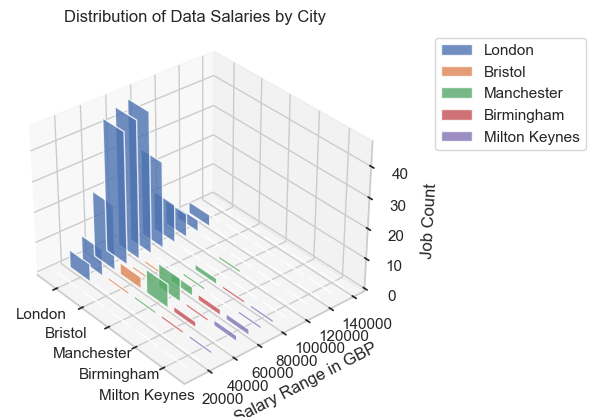

,city,average wage,total jobs,Salary between 0 and 10000,Salary between 10000 and 20000,Salary between 20000 and 30000,Salary between 30000 and 40000,Salary between 40000 and 50000,Salary between 50000 and 60000,Salary between 60000 and 70000,Salary between 70000 and 80000,Salary between 80000 and 90000,Salary between 90000 and 100000,Salary between 100000 and 110000,Salary between 110000 and 120000,Salary between 120000 and 130000,Salary between 130000 and 140000,Salary between 140000 and 150000,Salary between 150000 and 160000
4,Birmingham,52714.285714,7,0,0,1,2,1,2,0,1,0,0,0,0,0,0,0,0
7,Bristol,46714.285714,7,0,0,1,4,1,1,0,0,0,0,0,0,0,0,0,0
35,London,67217.510549,237,0,6,9,22,44,46,47,29,13,8,4,4,0,0,5,0
37,Manchester,53958.333333,24,0,0,1,8,8,3,1,2,0,1,0,0,0,0,0,0
39,Milton Keynes,57857.142857,7,0,0,1,0,2,2,1,1,0,0,0,0,0,0,0,0


In [13]:
# Define the salary ranges
salary_ranges = range(10000, 150000, 10000)

# Filter the data to include only jobs with the selected cities
selected_cities = ["Birmingham", "Bristol", "London", "Manchester", "Milton Keynes"]
filtered_data = df[df["city"].isin(selected_cities)]

# Create a list of city names
cities = filtered_data["city"].unique().tolist()

# Create a 3D histogram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, city in enumerate(cities):
    # Calculate job counts in each salary range for the current city
    job_counts = []
    for salary in salary_ranges:
        lower_bound = salary
        upper_bound = salary + 10000
        job_count = ((filtered_data["salary"] >= lower_bound) & (filtered_data["salary"] < upper_bound) & (filtered_data["city"] == city)).sum()
        job_counts.append(job_count)
    
    # Create a 3D bar for the current city
    xs = [i] * len(salary_ranges)
    ys = salary_ranges
    zs = job_counts
    ax.bar(xs, zs, ys, zdir='y', alpha=0.8, label=city)


ax.set_ylabel('Salary Range in GBP')
ax.set_zlabel('Job Count')
ax.view_init(elev=33, azim=-40)
ax.set_xticklabels(['','London','Bristol','Manchester','Birmingham','Milton Keynes'])
ax.set_title('Distribution of Data Salaries by City')
plt.legend(bbox_to_anchor=(1.13, 1.0), loc='upper left')
plt.show()
secondary_table

After looking at the distribution of all the cities with more than 6 vacancies. 
I have decided to look closely at London's market as not only do that have significantly more data points, but also the highest average.

Before looking exploring the data, I want to check out the distribution of the data.

# London Data

In [14]:
london_data = df[df['city'] == 'London']

## Visual Check of the Distribution

### Histogram

A histogram is a graphical representation of the distribution of a dataset. It provides a visual summary of the data's underlying frequency and distribution characteristics by dividing the data into bins or intervals and counting how many data points fall into each bin. Histograms are particularly useful for examining the shape, central tendency, and spread of data, and they can help identify skewness in the dataset.

<Axes: xlabel='salary', ylabel='Density'>

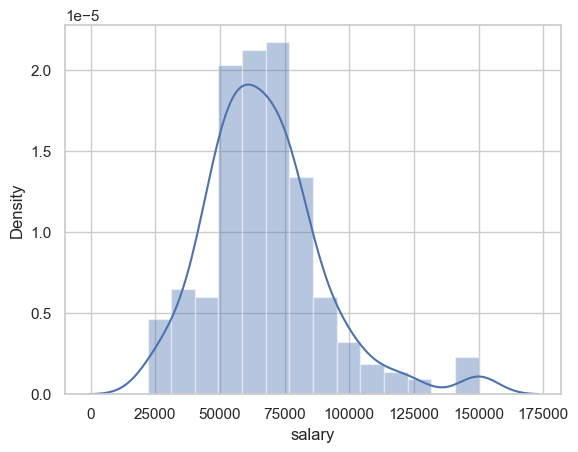

In [15]:
sns.distplot(london_data['salary'])

### Quantile Quantile plot

A Quantile-Quantile (Q-Q) plot is a graphical tool used in statistics to assess whether a dataset follows a particular theoretical distribution, typically the normal distribution. It is a type of probability plot that compares the quantiles of the dataset (observed values) with the quantiles of the theoretical distribution (expected values) on a scatterplot. The Q-Q plot is a valuable tool for visually determining how well your data fits a specific distribution and identifying departures from that distribution.

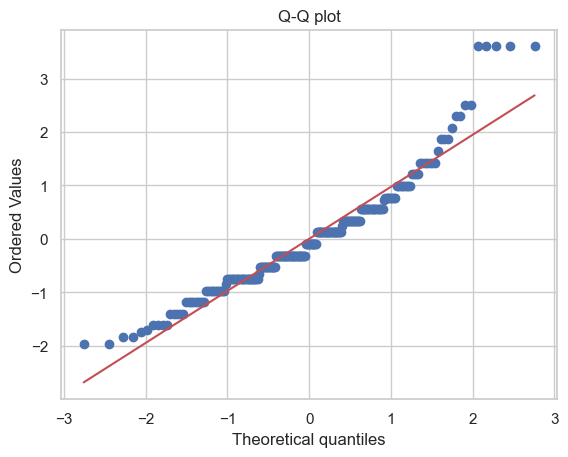

In [16]:
z = (london_data['salary'] -np.mean(london_data['salary']))/np.std(london_data['salary']) 
  
scipy.stats.probplot(z, dist="norm", plot=plt) 
plt.title("Q-Q plot") 
plt.show() 

### Conclusion

Using both of the graphs, we can see that there does not seem to be gaussian distribution (Normal Distribution). 
We are going to check this using D'Agostino and Pearson's Test as well as Anderson-Darling Test

## Statistical Check of the Distribution

### D'Agostino and Pearson's Test

D'Agostino and Pearson's Test, also known as the D'Agostino-Pearson test or simply the D'Agostino test, is a statistical test used to assess whether a dataset follows a normal distribution. It is named after the statisticians Ralph D'Agostino and Albert S. Pearson. This test is based on the idea that if the data is normally distributed, certain sample statistics (skewness and kurtosis) should be close to those expected in a normal distribution.

In [17]:
# normality test
statistic, p_value = stats.normaltest(london_data['salary'])
print('Statistics=%.3f, p=%.3f' % (statistic, p_value))
# interpret results
alpha = 0.05
if p_value < alpha:
    print("The data is not normally distributed (reject null hypothesis)")
else:
    print("The data appears to be normally distributed (fail to reject null hypothesis)")

Statistics=50.796, p=0.000
The data is not normally distributed (reject null hypothesis)


### Anderson-Darling Test

The Anderson-Darling test is a statistical test used to assess whether a dataset follows a specific distribution, typically the normal distribution. It is a variation of the Kolmogorov-Smirnov test, which checks how well the sample data fits a theoretical distribution by comparing the cumulative distribution function (CDF) of the sample data to the CDF of the theoretical distribution

In [18]:
# normality test
result = anderson(london_data['salary'])
print('Statistic: %.3f' % result.statistic)
p = 0
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 3.447
15.000: 0.567, data does not look normal (reject H0)
10.000: 0.645, data does not look normal (reject H0)
5.000: 0.774, data does not look normal (reject H0)
2.500: 0.903, data does not look normal (reject H0)
1.000: 1.074, data does not look normal (reject H0)


### Conclusion

After looking the results of both the visual and statistical check, we can conclude that the london data does not follow with a normal distribution.
This means when working with the data further such as doing an outlier check, I can not make the assumption of normality.

This will also be the fact when working with correlations between two variables, I will not be using Pearson's and instead be using Spearman's and/or Kendall Tau as they do not require the assumption of normality.

## Outlier Check

### Median Absolute Deviation

Using the Median Absolute Deviation (MAD) to find outliers is a method that doesn't rely on the assumption of a normal distribution.
As our data is non-normally distributed data, however, we want to avoid the influence of extreme values.

In [19]:
# Calculate the median
median = np.median(london_data['salary'])

# Calculate the Median Absolute Deviation (MAD)
mad = np.median(np.abs(london_data['salary'] - median))

# Define a threshold (e.g., 3 times MAD)
threshold = 3 * mad

# Find the outliers
outliers = [x for x in london_data['salary'] if np.abs(x - median) > threshold]

In [20]:
outliers.sort()

In [21]:
outliers

[115000.0,
 120000.0,
 120000.0,
 125000.0,
 125000.0,
 150000.0,
 150000.0,
 150000.0,
 150000.0,
 150000.0]

In [22]:
# Filter the data to keep only non-outliers
clean_london_data = london_data[(london_data['salary'] <= outliers[0])]

## How Years of Experience affects Salary

### Finding the amount of experience per year

In [23]:
def extract_experience(description):
    # Updated regular expression pattern to handle variations
    pattern = r'(\d+\s*(?:years?|yrs?)|(?:\d+\s*-\s*\d+\s*(?:years?|yrs?))|\d+\s*\+\s*(?:years?|yrs?)|\d+(?:(?:yrs?)|(?:years)))'
    matches = re.findall(pattern, description, re.IGNORECASE)
    
    if matches:
        # Extract the numeric parts and handle ranges and "+" signs
        years = []
        for match in matches:
            # Remove non-numeric characters
            match = re.sub(r'[^\d]+', '', match)
            
            if '-' in match:
                # Handle ranges by taking the lower bound
                lower_bound = int(match.split('-')[0])
                years.append(lower_bound)
            else:
                # Handle single values, "+" sign, and variations
                value = int(match.replace('+', '1000'))
                years.append(value)
        
        return str(min(years)) + " years"
    else:
        return None

clean_london_data['years of experience'] = clean_london_data['description'].apply(extract_experience)

In [24]:
clean_london_data.sample()

,title,advertiser,location,city,salary,description,job_category,years of experience
543,senior data engineer,Harnham,South East England,London,60000.0,Apply now\nSENIOR DATA ENGINEER\nINSURANCE\nLO...,data,None


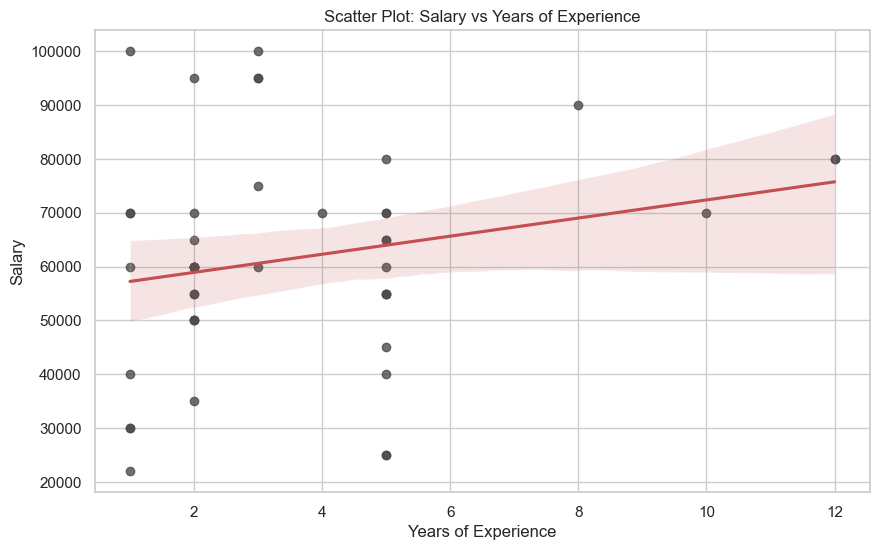

In [25]:
# Convert the "experience" column to a numeric format
def extract_years(experience):
    try:
        if '+' in experience:
            return int(experience.split('+')[0])
        elif '-' in experience:
            start, end = map(int, experience.split('-'))
            return (start + end) / 2
        else:
            return int(experience.split()[0])
    except:
        return None

clean_london_data['years of experience'] = clean_london_data['years of experience'].apply(extract_years)

clean_london_data_exp = clean_london_data[clean_london_data['years of experience'].notnull() & (clean_london_data['years of experience'] <= 100)]


# Create a scatter plot with a linear regression line
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.regplot(x='years of experience', y='salary', data=clean_london_data_exp, color=".3", line_kws=dict(color="r"))
plt.title("Scatter Plot: Salary vs Years of Experience")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()


In [26]:
scipy.stats.spearmanr(clean_london_data_exp['years of experience'], clean_london_data_exp['salary'])

SignificanceResult(statistic=0.23249845541385192, pvalue=0.11997519247407609)

In [27]:
scipy.stats.kendalltau(clean_london_data_exp['years of experience'], clean_london_data_exp['salary']) 

SignificanceResult(statistic=0.18527800143890072, pvalue=0.10732686460528215)

In [28]:
result = scipy.stats.linregress(clean_london_data_exp['years of experience'], clean_london_data_exp['salary'])
result.slope

1681.596752368065

In [29]:
# Where the linear regression line hits the Y axis inferring with no years of experience, this is the wage you should be earning.
result.intercept

55569.959404600806

In [30]:
# The correlation strength between years of experience and 
result.rvalue

0.22700631562794066

In [31]:
# The probability of the Null Hypothesis to be correct.
result.pvalue

0.12923024962268204

In [32]:
# Standard Deviation
result.stderr

1087.5993854789267

As illustrated on the graph and using other statistical methods such as Spearman's r coefficent.
We can denote that there is no correlation between years of experience and salary using our data; however, the lack of data points doesn't give us a definitive picture.
There are only 49 entries on roles that specifically mention an experience requirement in years. The other roles in our data set may ask for specific experience i.e. "managing a group of data engineers" which makes it impossible to quantitate. Despite this issue, I will check the years of experience against pay for different job titles.

In [33]:
pd.crosstab(index=clean_london_data_exp['title'], columns='count')

col_0,count
title,
customer data analytics manager,1
data and analytics delivery manager,1
data engineer,2
data engineer - online entertainment,1
data engineer - up to £90k,1
data engineering lead,1
data engineering manager,1
data science consultant,1
data scientist,6


### Standardising Job Titles

Looking at the titles of the jobs, we need standardise the names in order to make the comparison between different jobs.

In [34]:
# Changing the names of job titles in order to compare them.
clean_london_data_exp['title'] = np.where(clean_london_data_exp['title'].str.contains("data eng"), "data engineer", clean_london_data_exp['title'])
clean_london_data_exp['title'] = np.where(clean_london_data_exp['title'].str.contains("data sci"), "data scientist", clean_london_data_exp['title'])

In [35]:
pd.crosstab(index=clean_london_data_exp['title'], columns='count')

col_0,count
title,
customer data analytics manager,1
data and analytics delivery manager,1
data engineer,13
data scientist,25
head of engineering. global startup. big data,1
java software architect. data assets. global startup.,1
senior data analyst,2
"software engineer - big data, graph analytics, java",1
software engineering manager. global startup. big data,1


We are going to look at the two job titles with the highest population, that being "data engineer" and "data scientist"

### Exploration of the relationship between years of experience and salary for specific job titles

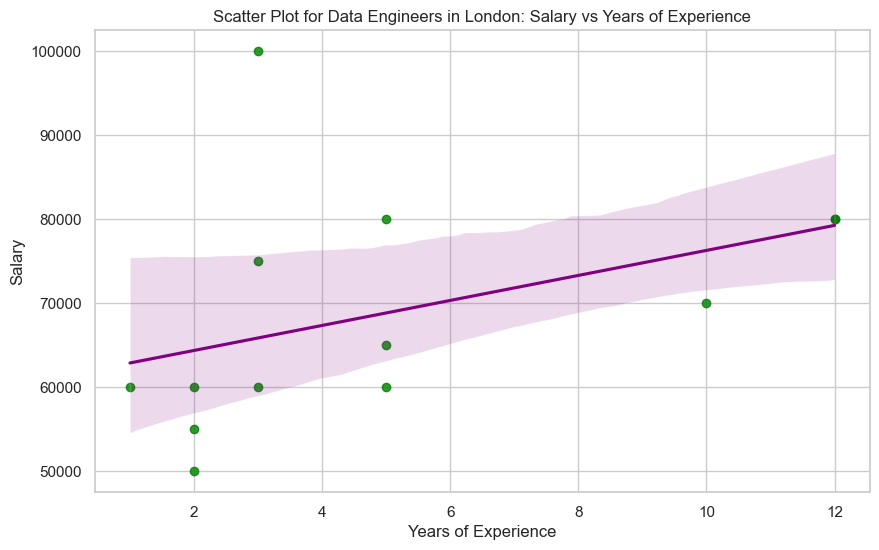

SignificanceResult(statistic=0.6533530185666604, pvalue=0.015452457354029182)

In [36]:
clean_london_eng = clean_london_data_exp[(clean_london_data_exp['title'] == "data engineer")]

# Create a scatter plot with a linear regression line
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.regplot(x='years of experience', y='salary', data=clean_london_eng, scatter_kws = {"color" : "green"}, line_kws = { "color" : "purple"})
plt.title("Scatter Plot for Data Engineers in London: Salary vs Years of Experience")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()
scipy.stats.spearmanr(clean_london_eng['years of experience'], clean_london_eng['salary'])

SignificanceResult(statistic=-0.10851746054978151, pvalue=0.6056183708984946)

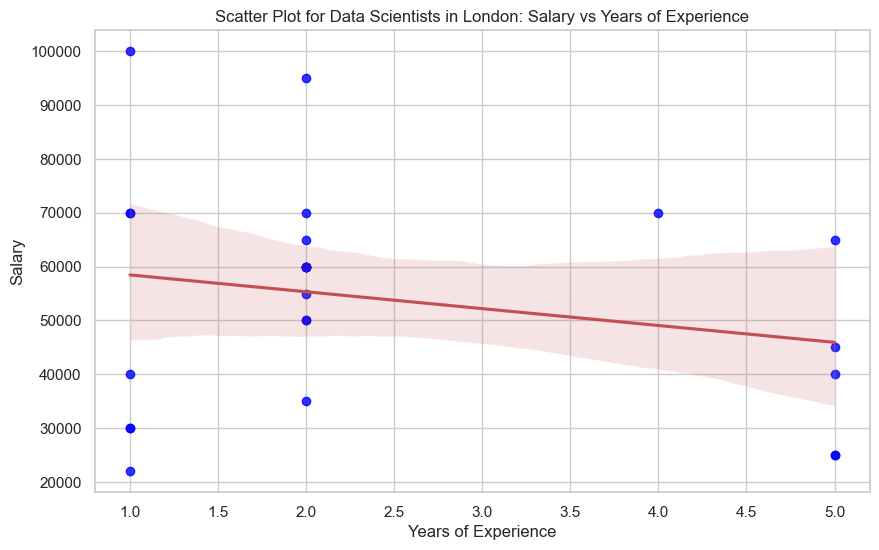

In [37]:
clean_london_sci = clean_london_data_exp[(clean_london_data_exp['title'] == "data scientist")]

# Create a scatter plot with a linear regression line
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.regplot(x='years of experience', y='salary', data=clean_london_sci, scatter_kws= {"color" : "blue"}, line_kws=dict(color="r"))
plt.title("Scatter Plot for Data Scientists in London: Salary vs Years of Experience")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show
scipy.stats.spearmanr(clean_london_sci['years of experience'], clean_london_sci['salary'])

### Conclusion

When splitting them by job title, we are able can see stronger correlations in the data, however, the p value are not low enough to show significance in the findings. 
This means that within this population of data, there is no correlation between years of experience and salary.

## Skills affect on Salary

I want to see if there is a correlation between the amount of skills required for the role and the salary.

In [38]:
corr_london_matrix_data = clean_london_data.copy()

In [39]:
corr_london_matrix_data['SQL'] = corr_london_matrix_data['description'].str.contains('sql', case=False).astype(int)
corr_london_matrix_data['Power Bi'] = corr_london_matrix_data['description'].str.contains('power bi', case=False).astype(int)
corr_london_matrix_data['Oracle'] = corr_london_matrix_data['description'].str.contains('Oracle', case=False).astype(int)
corr_london_matrix_data['Azure'] = corr_london_matrix_data['description'].str.contains('azure', case=False).astype(int)
corr_london_matrix_data['Python'] = corr_london_matrix_data['description'].str.contains('python', case=False).astype(int)

corr_london_matrix_data.drop(['years of experience', 'location', 'city','description','job_category'], axis=1, inplace=True)

corr_london_matrix_data['Total'] = corr_london_matrix_data.iloc[:, 3:8].sum(axis=1)

In [40]:
corr_london_matrix_data.head(10)

,title,advertiser,salary,SQL,Power Bi,Oracle,Azure,Python,Total
0,data science manager,Charles Simon Associates Ltd,70000.0,1,0,0,0,1,2
2,data science lead,Harnham,75000.0,1,0,0,0,1,2
4,data science manager,Data Idols,100000.0,0,0,0,0,0,0
5,data science consultant,Links Resourcing,65000.0,1,1,0,0,1,3
7,head of data science,Harnham,100000.0,0,0,0,0,0,0
8,head of data science,Harnham,115000.0,1,0,0,0,1,2
9,head of data science,Wade Macdonald,70000.0,1,0,0,1,1,3
12,product manager data science,Harnham,85000.0,0,0,0,0,1,1
13,lead data science consultant,Harnham,90000.0,0,0,0,0,1,1
14,lead data science consultant,Harnham,90000.0,0,0,0,0,0,0


In [41]:
# Create a function to determine seniority based on the "title" column
def determine_seniority(title):
    if any(x in title.lower() for x in ["head", "director", "senior", "principal"]):
        return "Senior"
    elif any(x in title.lower() for x in ["junior", "trainee", "graduate"]):
        return "Junior"
    else:
        return "Middle"

# Apply the function to create the "seniority" column
corr_london_matrix_data['Seniority'] = corr_london_matrix_data['title'].apply(determine_seniority)

In [42]:
# Changing the names of job titles in order to compare them.
corr_london_matrix_data['title'] = np.where(corr_london_matrix_data['title'].str.contains("data sci"), "Data Scientist", corr_london_matrix_data['title'])
corr_london_matrix_data['title'] = np.where(corr_london_matrix_data['title'].str.contains("data arch"), "Data Architect", corr_london_matrix_data['title'])
corr_london_matrix_data['title'] = np.where(corr_london_matrix_data['title'].str.contains("analyst"), "Data Analyst", corr_london_matrix_data['title'])
corr_london_matrix_data['title'] = np.where(corr_london_matrix_data['title'].str.contains("data eng"), "Data Engineer", corr_london_matrix_data['title'])

In [43]:
corr_london_matrix_data.sample()

,title,advertiser,salary,SQL,Power Bi,Oracle,Azure,Python,Total,Seniority
519,Data Engineer,Harnham,70000.0,1,1,0,0,1,3,Senior


In [44]:
rcol = (np.random.random(), np.random.random(), np.random.random())

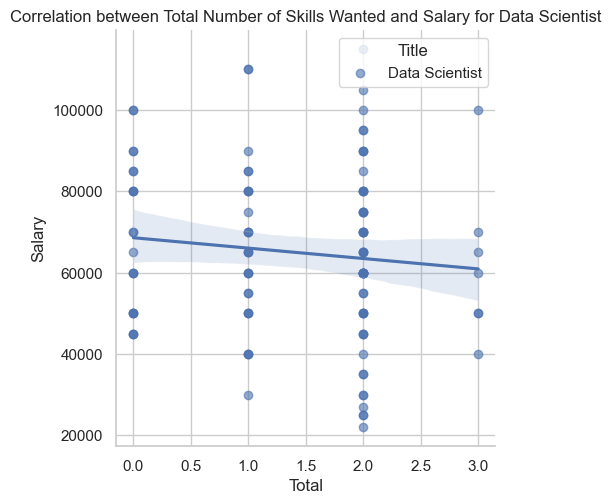

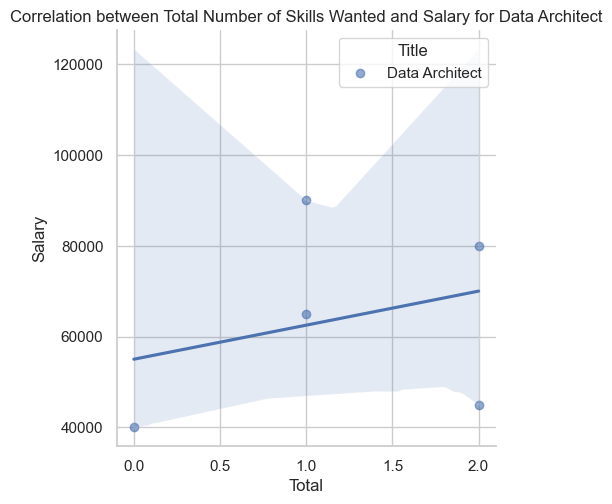

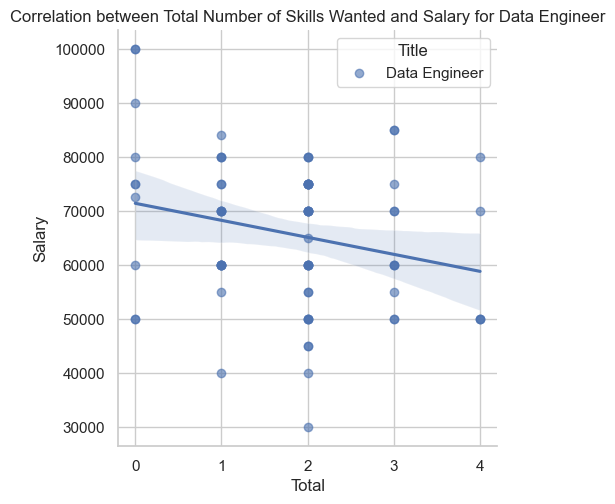

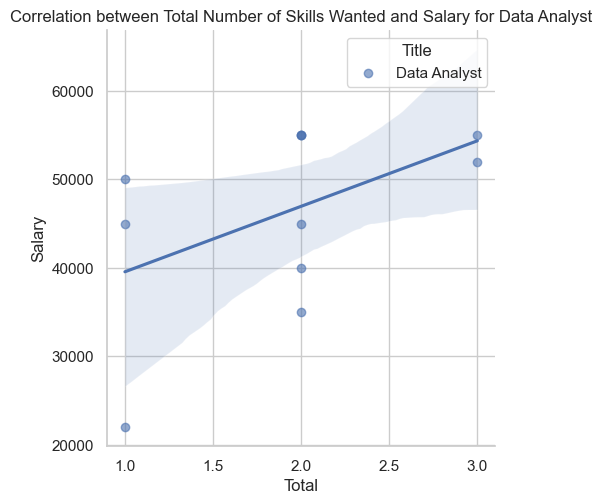

In [45]:
# Define the selected titles
selected_titles = ["Data Scientist", "Data Architect", "Data Engineer", "Data Analyst"]

# Iterate through the selected titles and create separate scatter plots with linear regression lines
for title in selected_titles:
    filtered_data = corr_london_matrix_data[corr_london_matrix_data['title'] == title]
    
    if not filtered_data.empty:
        # Create a scatter plot for the current title with a linear regression line
        sns.lmplot(x='Total', y='salary', data=filtered_data, hue='title', legend = False, scatter_kws={'alpha':0.6})
        
        # Add labels and title
        plt.xlabel("Total")
        plt.ylabel("Salary")
        plt.title(f"Correlation between Total Number of Skills Wanted and Salary for {title}")
        
        # Show the plot
        plt.legend(title="Title")
        plt.show()

In [46]:
# Iterate through the selected titles and calculate Spearman's correlation coefficient
for title in selected_titles:
    filtered_data = corr_london_matrix_data[corr_london_matrix_data['title'] == title]
    
    if not filtered_data.empty:
        # Calculate Spearman's correlation coefficient
        spearman_corr, p_value = stats.spearmanr(filtered_data['Total'], filtered_data['salary'])
        
        # Determine the significance level
        if p_value < 0.05:
            significance = "significant"
        else:
            significance = "not significant"
        
        # Print the results
        print(f"For {title}:")
        print(f"Spearman's rho: {spearman_corr:.3f}")
        print(f"Significance Level: {significance}\n")

For Data Scientist:
Spearman's rho: -0.104
Significance Level: not significant

For Data Architect:
Spearman's rho: 0.316
Significance Level: not significant

For Data Engineer:
Spearman's rho: -0.212
Significance Level: not significant

For Data Analyst:
Spearman's rho: 0.487
Significance Level: not significant



### Conclusion

After looking the results, there is no level of significance to infer that the amount of skills required for the roles affects the amount of salary.

# Conclusion on the totality of the research

During this research, the data shows there is no correlation between amount of skills required for a role and the salary, and the amount of experience and salary.
However, there is a problems with the data and the testing which boils down to the lack of data. Due to the small number of data, we are unable to get a conclusive answer to the questions asked as there are a multitude of different factors that couldn't be kept the same. An example of this is when looking at the affects of years of experience on salary is that we are unable to filter other factors such as sector, seniority level etc...